# Local Spatial Autocorrelation

Local spatial autocorrelation is a way to measure the degree of clustering or dispersion of a variable in a map. It is a local measure of spatial autocorrelation and it gives us more resolution than global spatial autocorrelation. It can be used 'as way to identify statistically meaningful local hot and cold spots spots of a variable in a segmentation map.

In this notebook, we will again be borrowing a lot from the great geographic datascience book by [Sergio J. Rey, Dani Arribas-Bel, Levi J. Wolf](https://geographicdata.science/book/notebooks/07_local_autocorrelation.html). It is a great resource for learning about spatial data science and although it is focused on the analysis of geographical maps, the analysis can be applied to any kind of segmentation maps as well.

> *Global measures of spatial autocorrelation are “whole map” statistics. They provide a single summary for an entire data set. For example, Moran’s 
 is a good tool to summarize a dataset into a single value that captures the degree of geographical clustering (or dispersion, if negative). However, Moran’s does not indicate areas within the map where specific types of values (e.g., high, low) are clustered, or instances of explicit dispersion. In other words, Moran’s I can tell us whether values in our map cluster together (or disperse) overall, but it will not inform us about where specific clusters (or outliers) are.* - [Sergio J. Rey, Dani Arribas-Bel, Levi J. Wolf](https://geographicdata.science/book/notebooks/07_local_autocorrelation.html)

> *Local measures of spatial autocorrelation focus on the relationships between each observation and its surroundings, rather than providing a single summary of these relationships across the map. In this sense, they are not summary statistics but scores that allow us to learn more about the spatial structure in our data. The general intuition behind the metrics however is similar to that of global ones. Some of them are even mathematically connected, where the global version can be decomposed into a collection of local ones.* - [Sergio J. Rey, Dani Arribas-Bel, Levi J. Wolf](https://geographicdata.science/book/notebooks/07_local_autocorrelation.html)


We will again be looking at the immune cell index that we coined in the [Global Autocorrelation]() example but this time we will be looking at the local spatial autocorrelation of this variable through the [local Moran's I satistic](https://en.wikipedia.org/wiki/Moran%27s_I). We will be using the same data as in the global autocorrelation notebook so this example starts identically until we will start computing the local autocorrelations.

## The Data

We will be using the same data as in the previous [Global Autocorrelation](./spatial_grids.md) example. The data is a cervical pre-cancerous biopsy and it is not publicly available, so this serves only as a demonstration of the functionality of `cellseg_gsontools`.

In [1]:
from pathlib import Path
from cellseg_gsontools import read_gdf

# tissue_path = Path("/path/to/cervix_lesion_tissues.geojson")
# nuc_path = Path("/path/to/cervix_lesion_nuclei.geojson")
tissue_path = Path("/media/leos/Expansion/laptop_data/datasets/CIN/fixed/areas_2022/areas_YP18-33583_1_HE_refined.geojson")
nuc_path = Path("/media/leos/Expansion/laptop_data/datasets/CIN/fixed/cells_2022/cells_YP18-33583_1_HE_refined.geojson")

tissues = read_gdf(tissue_path)[["geometry", "class_name"]] # take only relevant columns
nuclei = read_gdf(nuc_path)[["geometry", "class_name"]]

tissues.head(5)

,geometry,class_name
0,"POLYGON ((8726.00000 101404.00000, 8721.71000 ...",area_cin
1,"POLYGON ((8098.00000 102263.00000, 8095.19000 ...",area_cin
2,"POLYGON ((17873.00000 115644.00000, 17870.5200...",areastroma
3,"POLYGON ((16787.00000 100733.00000, 16773.7100...",areastroma
4,"POLYGON ((16387.00000 96785.00000, 16384.19000...",areastroma


In [2]:
nuclei.head(5)

,geometry,class_name
0,"POLYGON ((6679.00000 103882.02000, 6677.01000 ...",neoplastic
1,"POLYGON ((6726.00000 103493.02000, 6724.01000 ...",neoplastic
2,"POLYGON ((6755.01000 103504.01000, 6755.01000 ...",connective
3,"POLYGON ((6823.99000 103510.01000, 6823.00000 ...",connective
4,"POLYGON ((6760.00000 103443.02000, 6758.01000 ...",connective


<Axes: >

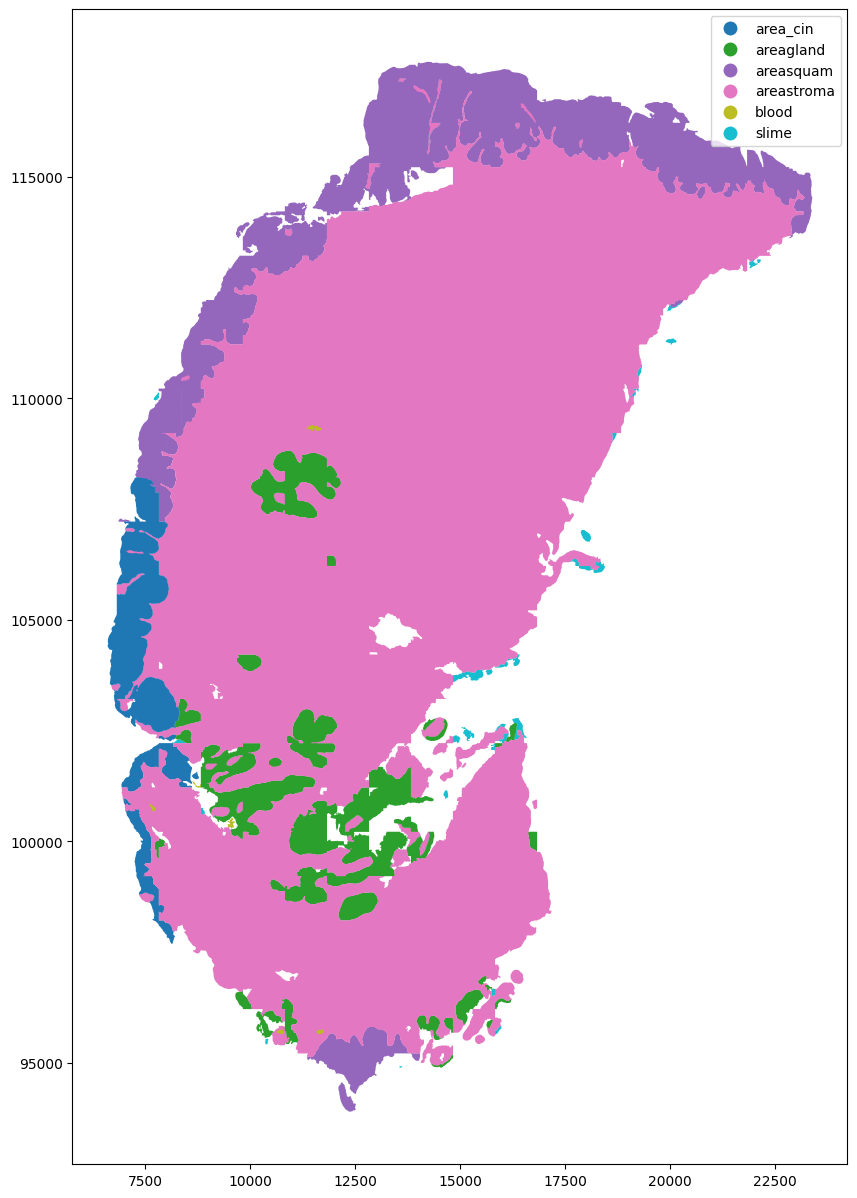

In [3]:
tissues.plot(figsize=(10, 15), column="class_name", legend=True, aspect=None)

<Axes: >

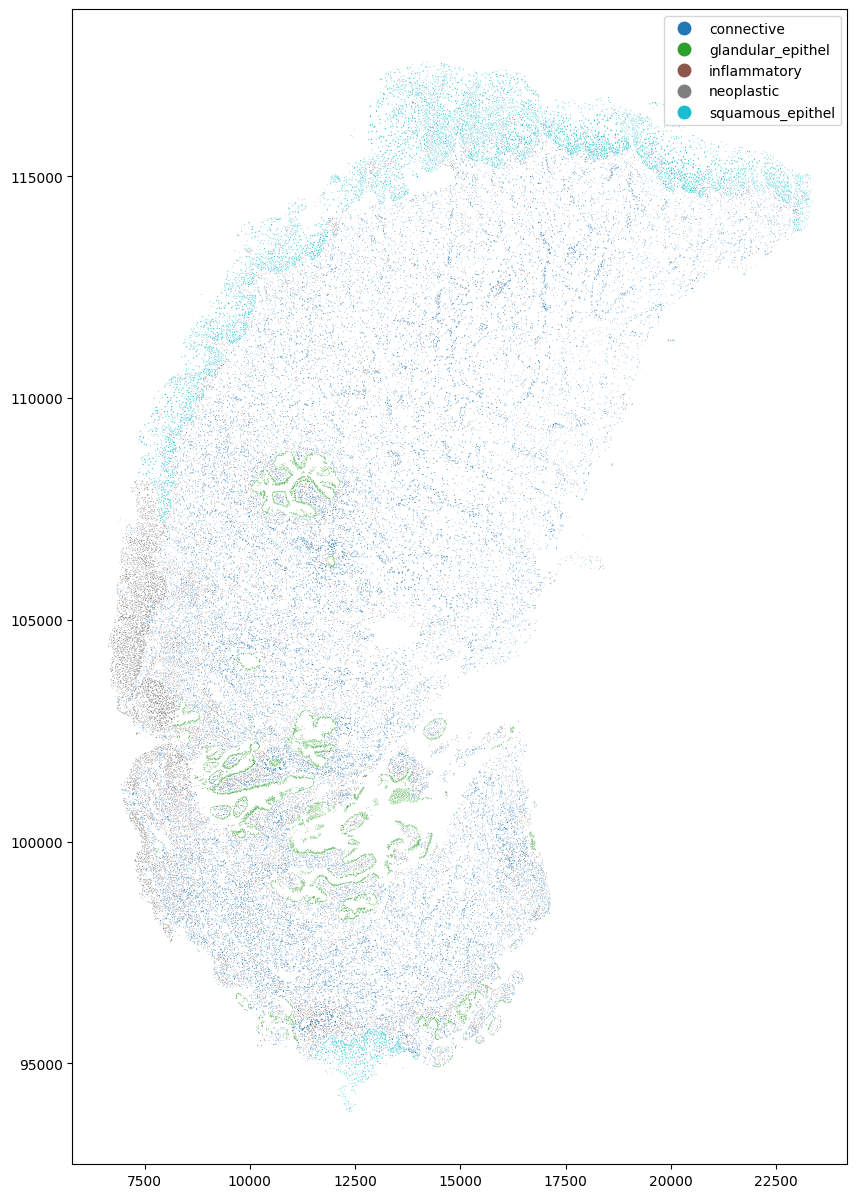

In [4]:
nuclei.plot(figsize=(10, 15), column="class_name", legend=True, aspect=None)

## Filtering the Cells in the Stroma

In this example, we will be looking at the spatial autocorrelation of cells within the stroma. Thus, we will filter only the cells within the stroma from the data.

In [5]:
stromaltissue = tissues.loc[tissues["class_name"] == "areastroma"]
stromaltissue.head(4)

,geometry,class_name
2,"POLYGON ((17873.00000 115644.00000, 17870.5200...",areastroma
3,"POLYGON ((16787.00000 100733.00000, 16773.7100...",areastroma
4,"POLYGON ((16387.00000 96785.00000, 16384.19000...",areastroma
5,"POLYGON ((16365.00000 116080.00000, 16360.9800...",areastroma


In [6]:
from cellseg_gsontools.utils import set_uid

stromalnuclei = nuclei.sjoin(stromaltissue, how="inner", predicate="within")

# we will set a new indexing for the filtered cells for the contiguity graph
# that is fitted next.
stromalnuclei = set_uid(stromalnuclei, id_col="uid", drop=False)

# take only relevant columns
stromalnuclei = stromalnuclei.loc[:, ["geometry", "class_name_left", "uid"]]
stromalnuclei.rename(columns={"class_name_left": "class_name"}, inplace=True)
stromalnuclei

,geometry,class_name,uid
uid,,,
0,"POLYGON ((6726.00000 103493.02000, 6724.01000 ...",neoplastic,0
1,"POLYGON ((6755.01000 103504.01000, 6755.01000 ...",connective,1
2,"POLYGON ((6823.99000 103510.01000, 6823.00000 ...",connective,2
3,"POLYGON ((6760.00000 103443.02000, 6758.01000 ...",connective,3
4,"POLYGON ((6848.01000 103481.02000, 6845.01000 ...",connective,4
...,...,...,...
45605,"POLYGON ((7217.01000 106533.02000, 7215.01000 ...",neoplastic,45605
45606,"POLYGON ((7390.00000 106510.02000, 7387.01000 ...",neoplastic,45606
45607,"POLYGON ((7133.75000 106514.00000, 7129.01000 ...",neoplastic,45607


<Axes: >

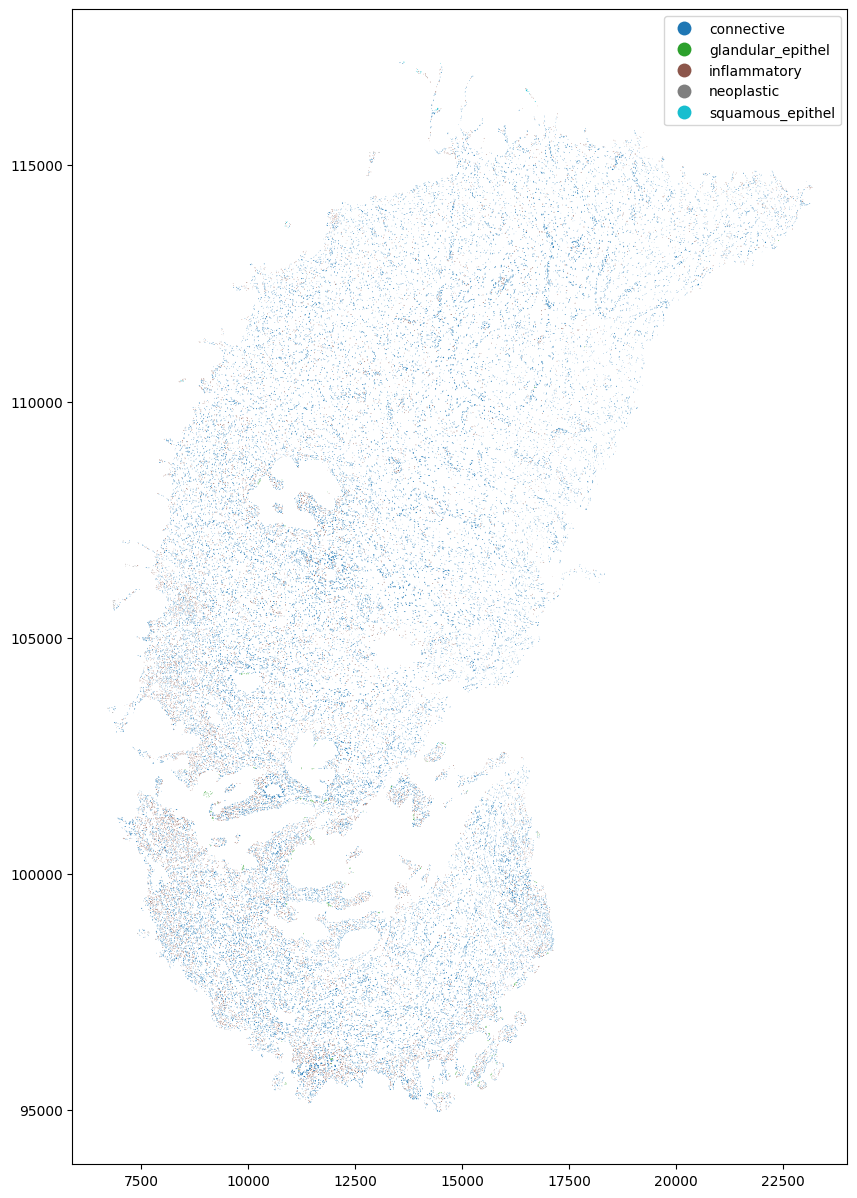

In [7]:
stromalnuclei.plot(
    figsize=(10, 15),
    column="class_name",
    legend=True,
    aspect=None,
)

## Spatial Weights

Next, we will fit a contiguity grpah on the cells, to extract the neighborhoods of each cell. We will use the `distband` contiguity graph, that connects each cell to all cells within a certain distance. We will use a distance of 50 microns (100 pixels since the segmentation was run done 20x magnification).

In [8]:
from cellseg_gsontools.graphs import fit_graph

w = fit_graph(
    stromalnuclei,
    type="distband",
    id_col="uid",
    thresh=100,
)

# Non-standardized weights
w.transform = "R"
w

## Neighborhood Immune Index.

Since we are interested in the local spatial autocorrelation of immune cell localization, we will calculate the count and fraction of the immune cells in each cell neighborhood. We will use these features to calculate an immune index (immune fraction $\times$ immune count) that we will use as the feature for the local autocorrelation analysis. The reason to use the immune index instead of the immune fraction is that the immune fraction will give high values for neihgborhoods with 1/1 or 2/2 immune cells which is are not very indicative of the actual clustering of immune cells whereas neighborhood of 9/9 immune cells would be indicative of clustering.

In [9]:
from cellseg_gsontools.apply import gdf_apply
from cellseg_gsontools.neighbors import neighborhood, nhood_vals, nhood_type_count
from functools import partial

# Get the neihgboring nodes of the graph
func = partial(neighborhood, spatial_weights=w)
stromalnuclei["nhood"] = gdf_apply(stromalnuclei, func, columns=["uid"])

# Get the classes of the neighboring nodes
func = partial(nhood_vals, values=stromalnuclei["class_name"])
stromalnuclei["nhood_classes"] = gdf_apply(
    stromalnuclei,
    func=func,
    parallel=True,
    columns=["nhood"],
)

# Get the number of inflammatory cells in the neighborhood
func = partial(nhood_type_count, cls="inflammatory", frac=False)
stromalnuclei["immune_cnt"] = gdf_apply(
    stromalnuclei,
    func=func,
    parallel=True,
    columns=["nhood_classes"],
)

# Get the fraction of inflammatory cells in the neighborhood
func = partial(nhood_type_count, cls="inflammatory", frac=True)
stromalnuclei["immune_frac"] = gdf_apply(
    stromalnuclei,
    func=func,
    parallel=True,
    columns=["nhood_classes"],
)

# This will smooth the extremes (e.g. if there is only one inflammatory cell in the 
# neighborhood, the fraction will be 1)
stromalnuclei["immune_index"] = stromalnuclei["immune_frac"] * stromalnuclei["immune_cnt"]

stromalnuclei

,geometry,class_name,uid,nhood,nhood_classes,immune_cnt,immune_frac,immune_index
uid,,,,,,,,
0,"POLYGON ((6726.00000 103493.02000, 6724.01000 ...",neoplastic,0,"[0, 1, 2, 3]","[neoplastic, connective, connective, connective]",0.0,0.000000,0.000000
1,"POLYGON ((6755.01000 103504.01000, 6755.01000 ...",connective,1,"[1, 0, 2, 3, 4]","[connective, neoplastic, connective, connectiv...",0.0,0.000000,0.000000
2,"POLYGON ((6823.99000 103510.01000, 6823.00000 ...",connective,2,"[2, 0, 1, 3, 4, 5, 6, 7]","[connective, neoplastic, connective, connectiv...",0.0,0.000000,0.000000
3,"POLYGON ((6760.00000 103443.02000, 6758.01000 ...",connective,3,"[3, 0, 1, 2, 8]","[connective, neoplastic, connective, connectiv...",0.0,0.000000,0.000000
4,"POLYGON ((6848.01000 103481.02000, 6845.01000 ...",connective,4,"[4, 1, 2, 5, 6, 7, 8]","[connective, connective, connective, connectiv...",0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...
45605,"POLYGON ((7217.01000 106533.02000, 7215.01000 ...",neoplastic,45605,"[45605, 45602, 45604, 45607, 45608, 45609]","[neoplastic, neoplastic, neoplastic, neoplasti...",1.0,0.166667,0.166667
45606,"POLYGON ((7390.00000 106510.02000, 7387.01000 ...",neoplastic,45606,"[45606, 45601, 45602, 45603]","[neoplastic, inflammatory, neoplastic, neoplas...",1.0,0.250000,0.250000
45607,"POLYGON ((7133.75000 106514.00000, 7129.01000 ...",neoplastic,45607,"[45607, 45604, 45605, 45608, 45609]","[neoplastic, neoplastic, neoplastic, inflammat...",1.0,0.200000,0.200000


## Spatial Lag and the Moran's Plot

Like in the global autocorrelation example, we will again compute the spatial lag here explicitly so that we can plot the Moran plot. Only this time, we will divide the plot in to quadrants. By doing this, we can divide cells in four groups based on their immune index variable. The quadrants meanings are: The cells at hand that have mostly immune cells as neighbors (high immune cell index) while the neighboring cells being the same i.e. also having neighbors that have high immune index (positive normalized values in Moran's plot). The second quadrant is the opposite: Cells that have few to none immune cells as neighbors (below-average immune index) while their neighbors also have low immune cell index (negative normalized values). Then the other two quadrants are those cells that have high immune index but their neighbors don't and vice versa. These four quadrants are named followingly: high-high (HH) (the top-right in Moran's plot), low-high (LH) (the top-left in Moran's plot), low-low (LL) (the bottom-left in Moran's plot), and high-low (HL) (the bottom-right in Moran's plot).

Let's first center the immune index variable.

In [10]:
# Standardize the immune_fraction column
stromalnuclei["immune_index_normed"] = (
    stromalnuclei["immune_index"] - stromalnuclei["immune_index"].mean()
)

# Let's look at the distribution of the immune cell counts when normalized immune index is > 0
stromalnuclei[stromalnuclei["immune_index_normed"] > 0]["immune_cnt"].value_counts(sort=False)

immune_cnt
4.0      872
6.0     2200
5.0     2017
3.0      153
10.0     856
7.0     1803
8.0     1287
2.0       20
9.0     1056
12.0     606
11.0     736
14.0     412
21.0      41
15.0     336
13.0     526
18.0     107
20.0      58
17.0     180
19.0      81
16.0     242
23.0      15
29.0       3
22.0      20
24.0      14
25.0       7
28.0       2
26.0       3
27.0       1
Name: count, dtype: int64

We can see that when we look at the immune counts at the cell neighborhoods for cells with normalized immune index greater than zero, they are all more or equal to 4. This means that the cells with HH immune index have at least 4 immune cells as neighbors.

Let's next plot the Moran's plot

Text(0.5, 1.0, 'Moran Plot Local')

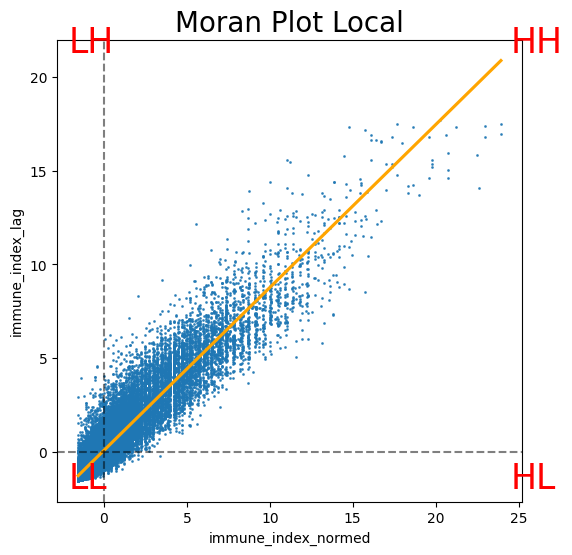

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from libpysal.weights import lag_spatial


def plot_moran(ax, val_col, lag_col, offset):
    # Plot values
    ax = sns.regplot(
        ax=ax,
        x=val_col,
        y=lag_col,
        data=stromalnuclei,
        ci=None,
        scatter_kws=dict(s=1),
        line_kws=dict(color="orange"),
    )

    ax.axvline(0, alpha=0.5, color="k", linestyle="--")
    ax.axhline(0, alpha=0.5, color="k", linestyle="--")
    
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    
    # Add text labels for each quadrant
    ax.text(xmax - offset, ymax - offset, "HH", fontsize=25, c="r")
    ax.text(xmax - offset, ymin + offset, "HL", fontsize=25, c="r")
    ax.text(xmin + offset, ymax - offset, "LH", fontsize=25, c="r")
    ax.text(xmin + offset, ymin + offset, "LL", fontsize=25, c="r")

    return ax

# Let's first compute the spatial lags
stromalnuclei["immune_index_lag"] = lag_spatial(w, stromalnuclei["immune_index_normed"].values)


# Set up the figure and axis
f, ax = plt.subplots(1, figsize=(6, 6))
ax = plot_moran(ax, "immune_index_normed", "immune_index_lag", offset=0.7)
ax.set_title("Moran Plot Local", fontsize=20)

Quite hard to get the text labels to fit in to the quadrants but you get the picture... These quadrants can be used to classify the nuclei residing in the stroma into four classes: HH-immune-index, LL-immune-index, HL-immune-index, and LH-immune-index. This will be done next with the help of the `esda` package. 

## Local Moran's I

Next we will compute the local Moran's I statistics for each observation of immune index in our data.

> *"The core idea of a local Moran’s is to identify cases in which the value of an observation and the average of its surroundings is either more similar i.e. high-high or low-low (HH or LL) or dissimilar high-low or low-high (HL, LH) than we would expect from pure chance. The mechanism to do this is similar to the one in the global Moran’s I, but it is applied in this case to each observation."* - [Sergio J. Rey, Dani Arribas-Bel, Levi J. Wolf](https://geographicdata.science/book/notebooks/07_local_autocorrelation.html)

Local Moran's I uses Local Indicators of Spatial Association (LISAs).

> *"LISAs are widely used in many fields to identify geographical clusters of values or find geographical outliers. They are a useful tool that can quickly return areas in which values are concentrated and provide suggestive evidence about the processes that might be at work. For these reasons, they have a prime place in the geographic data science toolbox."* - [Sergio J. Rey, Dani Arribas-Bel, Levi J. Wolf](https://geographicdata.science/book/notebooks/07_local_autocorrelation.html)

LISAs can be computed with the `esda` package very easily. We will compute the LISAs for the immune index next.

In [12]:
# !pip install esda

In [13]:
import esda
import numpy as np
import warnings

# suppress couple annoying warnings
warnings.filterwarnings('ignore')

# This is borrowed from:
# https://github.com/pysal/splot/blob/main/splot/_viz_utils.py
def moran_hot_cold_spots(moran_loc, p=0.05):
    sig = 1 * (moran_loc.p_sim < p)
    HH = 1 * (sig * moran_loc.q == 1)
    LL = 3 * (sig * moran_loc.q == 3)
    LH = 2 * (sig * moran_loc.q == 2)
    HL = 4 * (sig * moran_loc.q == 4)
    cluster = HH + LL + LH + HL
    return cluster


lisa_ifrac = esda.Moran_Local(
    stromalnuclei["immune_index_normed"], w, island_weight=np.nan
)
lisa_icnt = esda.Moran_Local(
    stromalnuclei["immune_index_normed"], w, island_weight=np.nan
)

# Let's classify the cells to HH, LL, LH, HL based on their immune_frac/cnt props
clusters = moran_hot_cold_spots(lisa_ifrac)

cluster_labels = ["ns", "HH", "LH", "LL", "HL"]
labels = [cluster_labels[i] for i in clusters]

stromalnuclei["immune_index_labels"] = labels
stromalnuclei

,geometry,class_name,uid,nhood,nhood_classes,immune_cnt,immune_frac,immune_index,immune_index_normed,immune_index_lag,immune_index_labels
uid,,,,,,,,,,,
0,"POLYGON ((6726.00000 103493.02000, 6724.01000 ...",neoplastic,0,"[0, 1, 2, 3]","[neoplastic, connective, connective, connective]",0.0,0.000000,0.000000,-1.550176,-1.550176,LL
1,"POLYGON ((6755.01000 103504.01000, 6755.01000 ...",connective,1,"[1, 0, 2, 3, 4]","[connective, neoplastic, connective, connectiv...",0.0,0.000000,0.000000,-1.550176,-1.550176,LL
2,"POLYGON ((6823.99000 103510.01000, 6823.00000 ...",connective,2,"[2, 0, 1, 3, 4, 5, 6, 7]","[connective, neoplastic, connective, connectiv...",0.0,0.000000,0.000000,-1.550176,-1.550176,LL
3,"POLYGON ((6760.00000 103443.02000, 6758.01000 ...",connective,3,"[3, 0, 1, 2, 8]","[connective, neoplastic, connective, connectiv...",0.0,0.000000,0.000000,-1.550176,-1.550176,LL
4,"POLYGON ((6848.01000 103481.02000, 6845.01000 ...",connective,4,"[4, 1, 2, 5, 6, 7, 8]","[connective, connective, connective, connectiv...",0.0,0.000000,0.000000,-1.550176,-1.550176,LL
...,...,...,...,...,...,...,...,...,...,...,...
45605,"POLYGON ((7217.01000 106533.02000, 7215.01000 ...",neoplastic,45605,"[45605, 45602, 45604, 45607, 45608, 45609]","[neoplastic, neoplastic, neoplastic, neoplasti...",1.0,0.166667,0.166667,-1.383510,-1.390176,LL
45606,"POLYGON ((7390.00000 106510.02000, 7387.01000 ...",neoplastic,45606,"[45606, 45601, 45602, 45603]","[neoplastic, inflammatory, neoplastic, neoplas...",1.0,0.250000,0.250000,-1.300176,-1.355732,ns
45607,"POLYGON ((7133.75000 106514.00000, 7129.01000 ...",neoplastic,45607,"[45607, 45604, 45605, 45608, 45609]","[neoplastic, neoplastic, neoplastic, inflammat...",1.0,0.200000,0.200000,-1.350176,-1.358510,ns


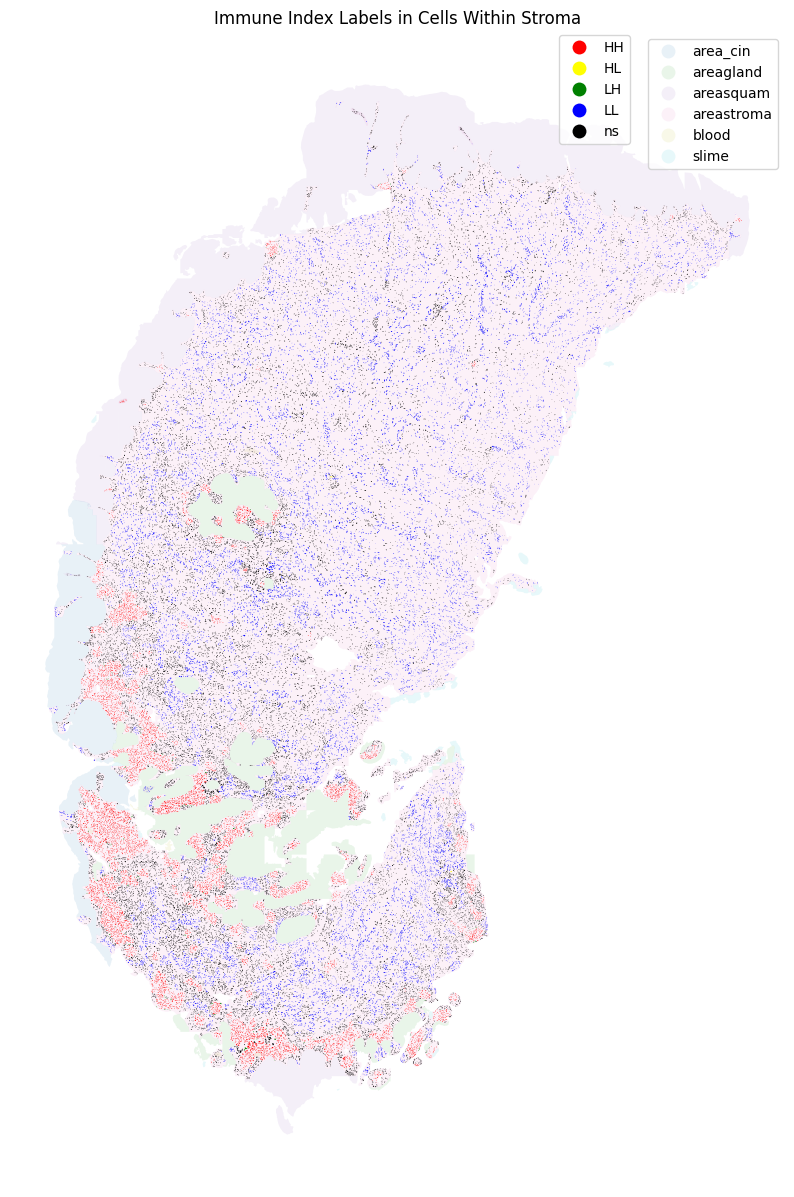

In [14]:
from matplotlib import colors

colors5= {
    "HH": "red",
    "LH": "green",
    "LL": "blue",
    "HL": "yellow",
    "ns": "black",
}
colormap = [colors5[i] for i in np.unique(labels)] 

hmap = colors.ListedColormap(colormap)

ax = tissues.plot(
    figsize=(10, 15),
    column="class_name",
    alpha=0.1,
    legend=True,
    aspect=None,
)

# add legend artist so it does not get overwritten
leg1 = ax.legend_
ax.add_artist(leg1)

ax = stromalnuclei.plot(
    ax=ax,
    column="immune_index_labels",
    categorical=True,
    legend=True,
    aspect=None,
    cmap=hmap,
    legend_kwds={"loc": "center left", "bbox_to_anchor": (0.7, 0.95)},
)
ax.set_title("Immune Index Labels in Cells Within Stroma")
ax.set_axis_off()

We can fairly confidently say that the red cells in the plot are statistically significant hotspots of cells surrounded by immune cells i.e. immune clusters. The blue cells, on the other hand, are statistically significant coldspots of cells with no immune cells in the surroundings.

## Tendency of Immune Cells to Form Clusters

Let's now take a bit closer look on the immune cells that belong in the red (HH) clusters and blues clusters (LL). We'll take a look at the proportion of immune cells belonging in both of the clusters to see whether there is an imbalance between LL and HH cells.

In [15]:
# Filter out the cells that are inflammatory and have HH an LL immune index label.
hhll_immune = stromalnuclei.loc[
    (stromalnuclei["class_name"] == "inflammatory") & 
    (stromalnuclei["immune_index_labels"].isin(["HH", "LL"]))
]


# Let's look at the proportion of HH and LL cells in the stroma.
(
    hhll_immune["immune_index_labels"].value_counts(),
    hhll_immune["immune_index_labels"].value_counts(normalize=True)
)

(immune_index_labels
 HH    4628
 LL     896
 Name: count, dtype: int64,
 immune_index_labels
 HH    0.837799
 LL    0.162201
 Name: proportion, dtype: float64)

We can see that the groups aren't very balanced in terms of the number of cells. Over 84 percent of all the immune cells in the stroma have a tendency to cluster together. This alone indicates that the immune cells in this sample are very clustered.

## Distance to Lesion

Let's further analyse how these cells spatially map in the tissue, especially in relation to the pre-cancerous lesion. Specifically, we will compute the distance of each cell to the lesion and plot the distance distributions of the cells in the HH and LL clusters.

We computed the minimum distance to the lesion in the [Spatial Grids]()-example, so we'll do the same here. Only this time we'll do it for the HH- and LL-immune-index cells instead of hexagonal grid cells.

In [16]:
import pandas as pd

# Helper function to get the distances of the cells to a given tissue class
def get_distances_to_tissue(nuclei, tissues, tissue_class):
    tissue = tissues.loc[tissues["class_name"] == tissue_class]
    
    distances = {}
    for i, poly in tissue.reset_index().iterrows():
        dist = nuclei.distance(poly.geometry)
        distances[i] = dist

    min_dists = pd.DataFrame(distances).min(axis=1)
    min_dists.name = f"min_dist_{tissue_class}"

    return nuclei.join(other=min_dists, how="left")

hhll_immune = get_distances_to_tissue(hhll_immune, tissues, "area_cin")
hhll_immune

,geometry,class_name,uid,nhood,nhood_classes,immune_cnt,immune_frac,immune_index,immune_index_normed,immune_index_lag,immune_index_labels,min_dist_area_cin
uid,,,,,,,,,,,,
21,"POLYGON ((7582.01000 98745.02000, 7581.01000 9...",inflammatory,21,"[21, 9, 10, 12, 13, 15, 18, 19, 20, 23, 24]","[inflammatory, connective, neoplastic, connect...",2.0,0.181818,0.363636,-1.186540,-1.084671,LL,57.938920
25,"POLYGON ((7295.00000 105945.02000, 7292.01000 ...",inflammatory,25,"[25, 40, 44, 45, 50, 51, 53]","[inflammatory, connective, connective, connect...",1.0,0.142857,0.142857,-1.407319,-1.372398,LL,19.958143
54,"POLYGON ((6888.01000 105776.02000, 6887.01000 ...",inflammatory,54,"[54, 29, 31, 33, 34, 36, 48, 55]","[inflammatory, neoplastic, neoplastic, neoplas...",2.0,0.250000,0.500000,-1.050176,-1.275098,LL,13.069129
87,"POLYGON ((9291.01000 100582.02000, 9288.01000 ...",inflammatory,87,"[87, 73, 77, 82, 83, 97, 99, 101, 110, 114, 115]","[inflammatory, connective, connective, connect...",6.0,0.545455,3.272727,1.722551,1.735480,HH,904.382513
92,"POLYGON ((9255.00000 100714.02000, 9248.01000 ...",inflammatory,92,"[92, 80, 81, 82, 90, 94, 95, 96, 97, 98, 100, ...","[inflammatory, connective, connective, connect...",7.0,0.583333,4.083333,2.533157,1.662764,HH,793.457037
...,...,...,...,...,...,...,...,...,...,...,...,...
45580,"POLYGON ((14531.01000 95263.02000, 14529.01000...",inflammatory,45580,"[45580, 45495, 45538, 45542, 45555, 45561, 455...","[inflammatory, inflammatory, connective, infla...",10.0,0.526316,5.263158,3.712982,2.244790,HH,6822.508018
45581,"POLYGON ((14198.01000 95238.02000, 14197.01000...",inflammatory,45581,"[45581, 45529, 45540, 45554, 45557, 45583, 455...","[inflammatory, connective, connective, connect...",1.0,0.125000,0.125000,-1.425176,-1.384647,LL,6521.387985
45590,"POLYGON ((14601.01000 95256.02000, 14599.01000...",inflammatory,45590,"[45590, 45499, 45538, 45542, 45546, 45549, 455...","[inflammatory, connective, connective, inflamm...",8.0,0.400000,3.200000,1.649824,1.627255,HH,6890.367988


Let's visualize the distance distributions.

In [17]:
# Let's tidy up the data first
tidy = hhll_immune.reset_index(drop=True).set_index("immune_index_labels")
tidy = tidy[["min_dist_area_cin"]]
tidy = tidy.stack()
tidy = tidy.reset_index()
tidy = tidy.rename(
    columns={
        "immune_index_labels": "Immune Index Cells",
        "level_1": "Attribute",
        0: "Distance to Lesion"
    }
)
tidy

,Immune Index Cells,Attribute,Distance to Lesion
0,LL,min_dist_area_cin,57.938920
1,LL,min_dist_area_cin,19.958143
2,LL,min_dist_area_cin,13.069129
3,HH,min_dist_area_cin,904.382513
4,HH,min_dist_area_cin,793.457037
...,...,...,...
5519,HH,min_dist_area_cin,6822.508018
5520,LL,min_dist_area_cin,6521.387985
5521,HH,min_dist_area_cin,6890.367988
5522,HH,min_dist_area_cin,6796.483901


Text(0.5, 1.0, 'Distance of HH and LL Inflammatory Cells to Lesion')

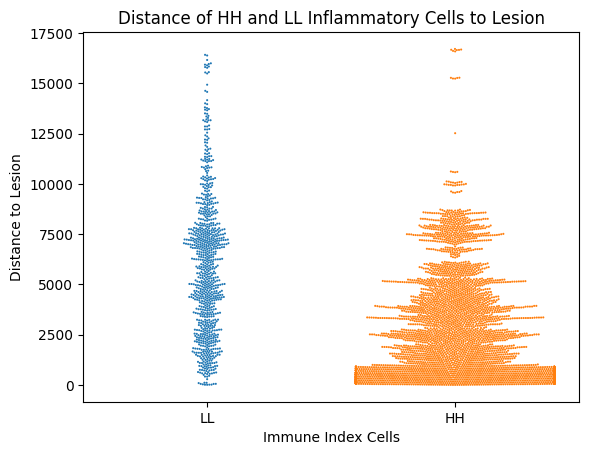

In [18]:
ax = sns.swarmplot(
    data=tidy,
    y="Distance to Lesion",
    x="Immune Index Cells",
    hue="Immune Index Cells",
    size=1.5,
    orient="v",
    legend=False,
    warn_thresh=0.5,
)
ax.set_title("Distance of HH and LL Inflammatory Cells to Lesion")

From the plot above we can see that the LL-immune-index cells have more evenly distributed distances to lesion than the HH cells. This indicates that the HH cells tend to cluster closer to the lesion

Let's do a t-test on two independent samples to see if the difference in the mean distances is statistically significant. We'll use the `scipy.stats.ttest_ind` function for this.

In [19]:
from scipy.stats import ttest_ind

# Filter the immune hot and cold hexes
immune_hot = hhll_immune.loc[hhll_immune["immune_index_labels"] == "HH"]
immune_cold = hhll_immune.loc[hhll_immune["immune_index_labels"] == "LL"]

# standardize the distances
immune_hot["min_dist_area_cin"] = (
    immune_hot["min_dist_area_cin"] / immune_hot["min_dist_area_cin"].mean()
) / immune_hot["min_dist_area_cin"].std()
immune_cold["min_dist_area_cin"] = (
    immune_cold["min_dist_area_cin"] / immune_cold["min_dist_area_cin"].mean()
) / immune_cold["min_dist_area_cin"].std()

# Get the distances for immune hot and cold hexes
dist_hot = immune_hot["min_dist_area_cin"]
dist_cold = immune_cold["min_dist_area_cin"]

# Perform the t-test test
statistic, p_value = ttest_ind(dist_hot, dist_cold)

# Print the results
if p_value < 0.05:
    print("The HH cells are significantly closer to the lesion than the LL cells.")
else:
    print("There is no significant difference in distance between the LL and HH cells.")

print("p-value: ", p_value)

The HH cells are significantly closer to the lesion than the LL cells.
p-value:  6.796636548380461e-14


Let's plot the standardized distance distributions of the HH and LL cells.

<Axes: title={'center': 'HH (Red), LL (Blue), Distance to Lesion with Means (Dashed)'}, xlabel='min_dist_area_cin', ylabel='Density'>

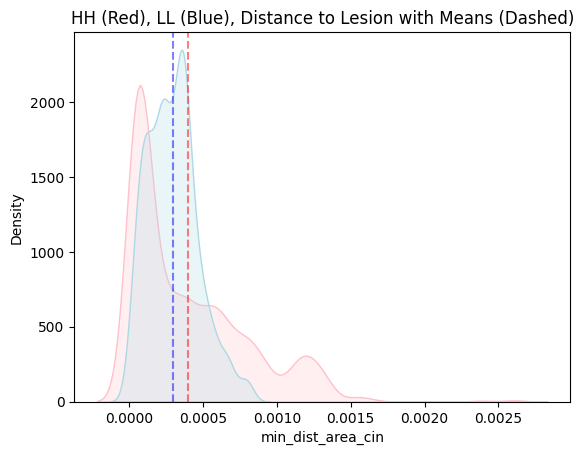

In [20]:
ax = sns.kdeplot(
    immune_hot["min_dist_area_cin"],
    label="HH",
    shade=True,
    color="pink"
)
ax = sns.kdeplot(
    immune_cold["min_dist_area_cin"],
    label="LL",
    shade=True,
    color="lightblue",
    ax=ax
)
ax.axvline(
    immune_cold["min_dist_area_cin"].mean(),
    color="b",
    linestyle="--",
    alpha=0.5
)
ax.axvline(
    immune_hot["min_dist_area_cin"].mean(),
    color="r",
    linestyle="--",
    alpha=0.5
)

ax.set_title("HH (Red), LL (Blue), Distance to Lesion with Means (Dashed)")
ax

From these analyses, it is fair to say that the immune cells in the HH clusters are more likely to be closer to the lesion than the immune cells in the LL clusters. This is a very interesting finding since it indicates that the immune cells in the HH clusters are more likely to be in the vicinity of the lesion and thus more likely to be in the vicinity of the cancer cells.

## Distance to Other Tissues

Now we will subset only the HH-immune-index cells and examine the distance distributions of these cells to the other tissues in the sample. We want to see what is the proportion of HH cells that are in the vicinity of the lesion and what is the proportion of HH cells that are in the vicinity of the other tissues.

In [21]:
hh_immune = hhll_immune.loc[hhll_immune["immune_index_labels"] == "HH"]
hh_immune = get_distances_to_tissue(hh_immune, tissues, "areasquam")
hh_immune = get_distances_to_tissue(hh_immune, tissues, "areagland")
hh_immune

,geometry,class_name,uid,nhood,nhood_classes,immune_cnt,immune_frac,immune_index,immune_index_normed,immune_index_lag,immune_index_labels,min_dist_area_cin,min_dist_areasquam,min_dist_areagland
uid,,,,,,,,,,,,,,
87,"POLYGON ((9291.01000 100582.02000, 9288.01000 ...",inflammatory,87,"[87, 73, 77, 82, 83, 97, 99, 101, 110, 114, 115]","[inflammatory, connective, connective, connect...",6.0,0.545455,3.272727,1.722551,1.735480,HH,904.382513,5565.533920,16.098727
92,"POLYGON ((9255.00000 100714.02000, 9248.01000 ...",inflammatory,92,"[92, 80, 81, 82, 90, 94, 95, 96, 97, 98, 100, ...","[inflammatory, connective, connective, connect...",7.0,0.583333,4.083333,2.533157,1.662764,HH,793.457037,5699.122822,43.310743
94,"POLYGON ((9293.01000 100711.02000, 9291.01000 ...",inflammatory,94,"[94, 74, 80, 81, 82, 90, 92, 95, 100, 105, 106...","[inflammatory, connective, connective, connect...",5.0,0.384615,1.923077,0.372901,1.725660,HH,833.468542,5677.527121,53.255238
95,"POLYGON ((9310.00000 100685.02000, 9307.01000 ...",inflammatory,95,"[95, 74, 80, 81, 82, 92, 94, 100, 102, 105, 10...","[inflammatory, connective, connective, connect...",6.0,0.428571,2.571429,1.021252,1.471052,HH,860.662565,5647.113536,80.326462
99,"POLYGON ((9230.01000 100579.02000, 9229.01000 ...",inflammatory,99,"[99, 77, 82, 83, 87, 97, 101, 110, 115]","[inflammatory, connective, connective, inflamm...",5.0,0.555556,2.777778,1.227602,2.022172,HH,877.060665,5588.749607,10.020000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45572,"POLYGON ((14445.01000 95259.02000, 14444.01000...",inflammatory,45572,"[45572, 45505, 45525, 45542, 45548, 45555, 455...","[inflammatory, connective, inflammatory, infla...",9.0,0.473684,4.263158,2.712982,1.865569,HH,6742.895678,399.331642,243.050000
45580,"POLYGON ((14531.01000 95263.02000, 14529.01000...",inflammatory,45580,"[45580, 45495, 45538, 45542, 45555, 45561, 455...","[inflammatory, inflammatory, connective, infla...",10.0,0.526316,5.263158,3.712982,2.244790,HH,6822.508018,484.494815,252.985907
45590,"POLYGON ((14601.01000 95256.02000, 14599.01000...",inflammatory,45590,"[45590, 45499, 45538, 45542, 45546, 45549, 455...","[inflammatory, connective, connective, inflamm...",8.0,0.400000,3.200000,1.649824,1.627255,HH,6890.367988,553.539773,198.006415


In [22]:
# get the closest tissue class
hh_immune["closest_tissue"] = hh_immune[
    ["min_dist_area_cin", "min_dist_areasquam", "min_dist_areagland"]
].idxmin(axis=1).str.replace("min_dist_", "closest_to_")

# get the distance to the closest tissue class
hh_immune["min_dist_to_tissue"] = hh_immune[
    ["min_dist_area_cin", "min_dist_areasquam", "min_dist_areagland"]
].min(axis=1)

(
    hh_immune["closest_tissue"].value_counts(),
    hh_immune["closest_tissue"].value_counts(normalize=True)
)

(closest_tissue
 closest_to_areagland    3007
 closest_to_area_cin     1216
 closest_to_areasquam     405
 Name: count, dtype: int64,
 closest_tissue
 closest_to_areagland    0.649741
 closest_to_area_cin     0.262748
 closest_to_areasquam    0.087511
 Name: proportion, dtype: float64)

From the above results we can see the proportion of HH cells to different epithelial tissues. We can see that the majority of the HH cells are actually closer to the glandular epithelium than the lesion. Glands in cervical tissue are often sources of immune cells so it is natural that most of the immune cells are closer to the glands than the lesion.

Let's next plot the distributions of the distances of the HH cells to these tissues.

In [23]:
# Let's tidy up the data first
tidy = hh_immune.reset_index(drop=True).set_index("closest_tissue")
tidy = tidy[["min_dist_to_tissue"]]
tidy = tidy.stack()
tidy = tidy.reset_index()
tidy = tidy.rename(
    columns={
        "closest_tissue": "Closest Tissue",
        "level_1": "Attribute",
        0: "Distance to Tissue"
    }
)
tidy

,Closest Tissue,Attribute,Distance to Tissue
0,closest_to_areagland,min_dist_to_tissue,16.098727
1,closest_to_areagland,min_dist_to_tissue,43.310743
2,closest_to_areagland,min_dist_to_tissue,53.255238
3,closest_to_areagland,min_dist_to_tissue,80.326462
4,closest_to_areagland,min_dist_to_tissue,10.020000
...,...,...,...
4623,closest_to_areagland,min_dist_to_tissue,243.050000
4624,closest_to_areagland,min_dist_to_tissue,252.985907
4625,closest_to_areagland,min_dist_to_tissue,198.006415
4626,closest_to_areagland,min_dist_to_tissue,258.142094


Text(0.5, 1.0, 'KDE - Distance to Closest Tissue')

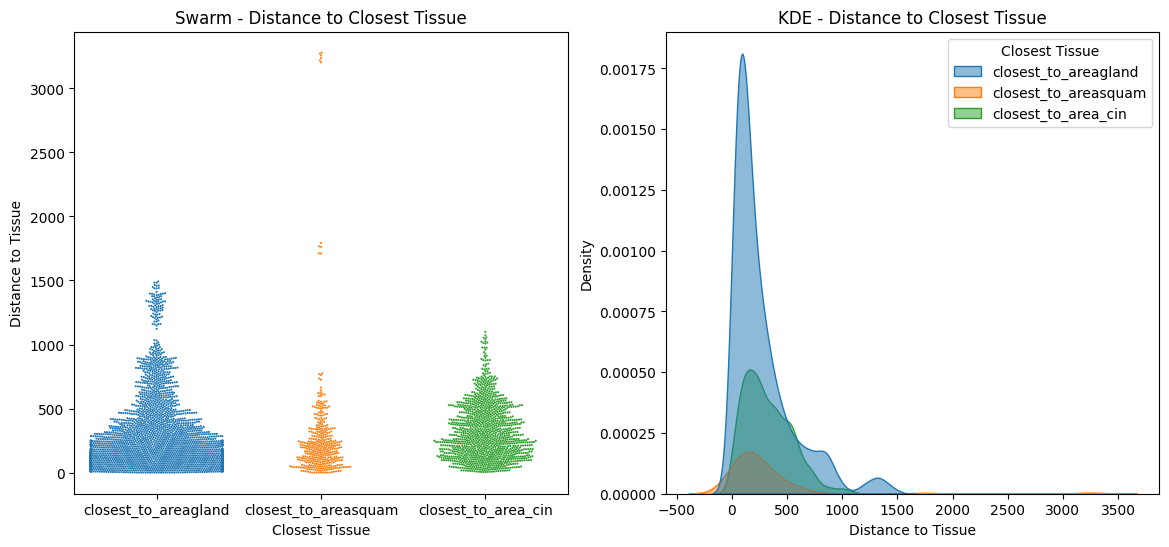

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

sns.swarmplot(
    ax=ax[0],
    data=tidy,
    y="Distance to Tissue",
    x="Closest Tissue",
    hue="Closest Tissue",
    size=1.5,
    orient="v",
    legend=False,
    warn_thresh=0.5,
)

sns.kdeplot(
    ax=ax[1],
    data=tidy,
    x="Distance to Tissue",
    hue="Closest Tissue",
    fill=True,
    alpha=0.5,
)

ax[0].set_title("Swarm - Distance to Closest Tissue")
ax[1].set_title("KDE - Distance to Closest Tissue")

Let's plot how the HH immune cells are distributed in the tissue and color them based on the `closest_tissue` variable.

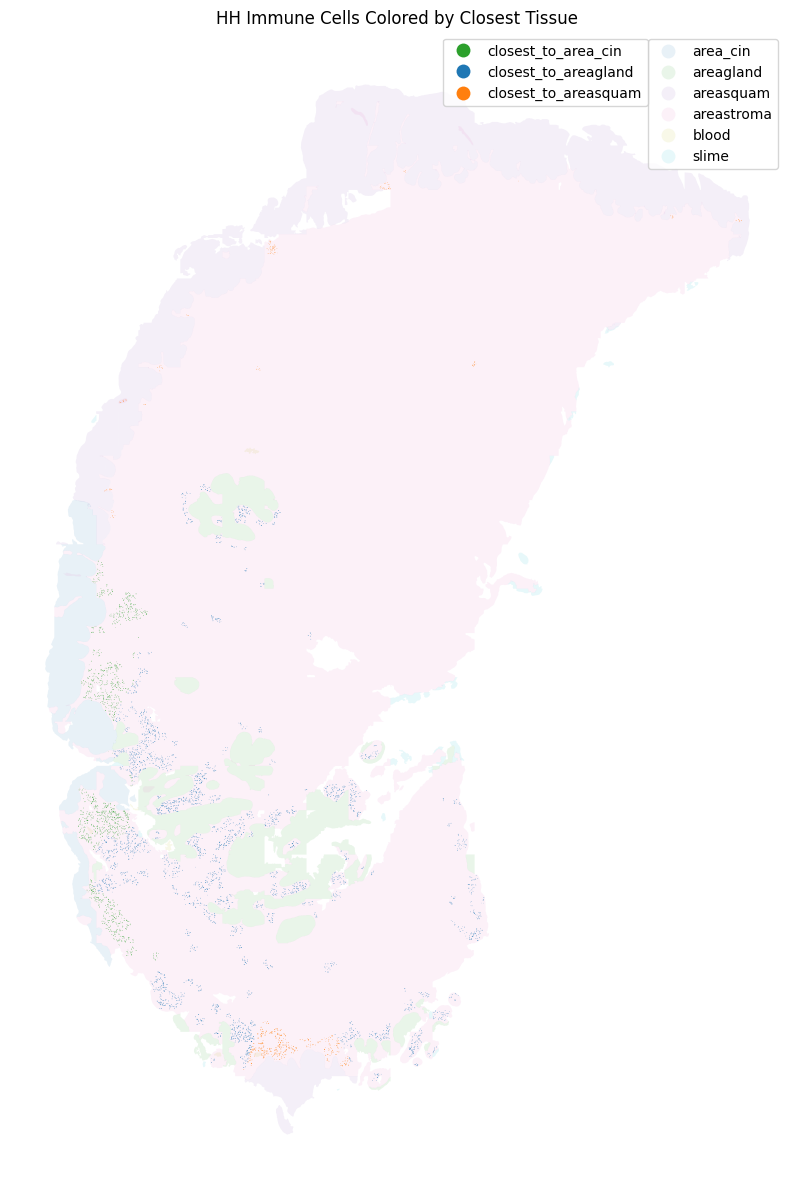

In [25]:
from matplotlib import colors

pal = sns.color_palette("tab10").as_hex()

colors5= {
    "closest_to_areagland": pal[0],
    "closest_to_areasquam": pal[1],
    "closest_to_area_cin": pal[2],
}
colormap = [colors5[i] for i in np.unique(hh_immune["closest_tissue"])] 

hmap = colors.ListedColormap(colormap)

ax = tissues.plot(
    figsize=(10, 15),
    column="class_name",
    alpha=0.1,
    legend=True,
    aspect=None,
)

# add legend artist so it does not get overwritten
leg1 = ax.legend_
ax.add_artist(leg1)

ax = hh_immune.plot(
    ax=ax,
    column="closest_tissue",
    categorical=True,
    legend=True,
    aspect=None,
    cmap=hmap,
    legend_kwds={"loc": "center left", "bbox_to_anchor": (0.55, 0.965)},
)

ax.set_title("HH Immune Cells Colored by Closest Tissue")
ax.set_axis_off()

From the reuslts above it's quite clear that not all of the HH immune cells in the tissue reside in the vicinity of the lesion. In fact, the majority of the HH immune cells are in the vicinity of the glandular epithelium. This should be taken into account too when interpreting the results of the local autocorrelation analysis.